<a href="https://colab.research.google.com/github/alessandro-crescenzi/computer_vision_project/blob/main/Traffic_Sign_Training_(12_Classes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the dataset from: https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html

The training set is: GTSRB_Online-Test-Images-Sorted.zip
The test set is: GTSRB_Online-Test-Images-Sorted.zip

In [ ]:
!pip3 install deeplake

In [24]:
import deeplake
import torch
from torchvision import transforms, models

train = deeplake.load("hub://activeloop/gtsrb-train")
test = deeplake.load("hub://activeloop/gtsrb-test")

hub://activeloop/gtsrb-train loaded successfully.

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtsrb-train

hub://activeloop/gtsrb-test loaded successfully.

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtsrb-test



In [1]:
import torch
from torchvision import transforms, datasets, models
from google.colab import drive
drive.mount('/content/drive')

mount_folder = '/content/drive/My Drive'

Mounted at /content/drive


In [2]:
!ls '/content/drive/My Drive/train_images/GTSRB/Final_Training/Images'

ls: cannot access '/content/drive/My Drive/train_images/GTSRB/Final_Training/Images': No such file or directory


In [ ]:
!ls '/content/drive/My Drive/train_images/GTSRB/Final_Training/Images/00000'

In [ ]:
!ls '/content/drive/My Drive/test_images/GTSRB/Online-Test-sort/00000'

img


In [ ]:
!ls -a '/content/prova'

.  ..  0


In [ ]:
rm -rf '/content/prova/.ipynb_checkpoints'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


In [35]:
import zipfile
import os

train_zip = mount_folder + '/GTSRB_Final_Training_Images.zip'
test_zip = mount_folder + '/GTSRB_Online-Test-Images-Sorted.zip'

if not os.path.exists(train_zip) or not os.path.exists(test_zip):
    raise(RuntimeError("Could not find " + train_zip + " and/or " + test_zip
          + ', download them from https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html'))
    
# Extract train_data.zip
train_folder = mount_folder + '/train_images'
if not os.path.isdir(train_folder):
    print(train_folder + ' not found, extracting ' + train_zip)
    zip_ref = zipfile.ZipFile(train_zip, 'r')
    zip_ref.extractall(train_folder)
    zip_ref.close()
    
# Extract test_data.zip
test_folder = mount_folder + '/test_images'
if not os.path.isdir(test_folder):
    print(test_folder + ' not found, extracting ' + test_zip)
    zip_ref = zipfile.ZipFile(test_zip, 'r')
    zip_ref.extractall(test_folder)
    zip_ref.close()

train_folder= train_folder + '/GTSRB/Final_Training/Images'
#new_train_folder = mount_folder + '/GTSRB_train'

test_folder= test_folder + '/GTSRB/Online-Test-sort'
folder_to_remove = test_folder + '/Images'
#new_test_folder= test_folder + '/GTSRB/Online-Test-sort'

!rm -rf "$folder_to_remove"

#!mv "$train_folder" "$new_train_folder"
#!mv "$test_folder" "$new_train_folder"

classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
 		        21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

We are only interested in recognizing speed limits and stop signs for our purposes (classes 0-8, 13, 14, 32), we set the others to a unique class "unknown"

In [ ]:
import pathlib

'''
#Remove leading zeros in Train Data directories 

for folder_name in os.listdir(train_folder):
    if folder_name == '00000' or folder_name == '0':
       clean = '0'
    else:
       clean = folder_name.lstrip('0')

    if (folder_name != clean):
        os.rename (os.path.join(train_folder, folder_name),os.path.join(train_folder, clean))

#Remove leading zeros in Test Data directories 

for folder_name in os.listdir(test_folder):
    if folder_name == '00000' or folder_name == '0':
       clean = '0'
    else:
       clean = folder_name.lstrip('0')

    if (folder_name != clean):
        os.rename (os.path.join(test_folder, folder_name),os.path.join(test_folder, clean))
'''

mapping = { "00000": "00000", "00001": "00001", "00002": "00002", "00003": "00003", "00004": "00004", "00005": "00005", "00006": "00006", "00007": "00007", "00008": "00008", "00013": "00009", "00014": "00010", "00032": "00011" }
unknown = "00012"

#Append name of folder to every file in training folder, then apply mapping 
for folder_name in os.listdir(train_folder):

    folder_path = os.path.join(train_folder, folder_name)

    if os.path.isdir(folder_path):
      
      for file_name in os.listdir(folder_path):
          file_extension = pathlib.Path(file_name).suffix
          file_no_extension = file_name.replace(file_extension, "")
          #os.rename (os.path.join(folder_path, file_name),os.path.join(folder_path, file_no_extension + "_" + folder_name + file_extension))

          if mapping.get(folder_name) is not None:
            os.rename (os.path.join(folder_path, file_name),os.path.join(os.path.join(train_folder, mapping[folder_name]), file_no_extension + "_" + folder_name + file_extension))
          else:
            os.rename (os.path.join(folder_path, file_name),os.path.join(os.path.join(train_folder, unknown), file_no_extension + "_" + folder_name + file_extension))
      
#Delete empty folders in training folder
for folder_name in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, folder_name)

    if os.path.isdir(folder_path) and not os.listdir(folder_path):
       os.rmdir(folder_path)

#Append name of folder to every file in test folder, then apply mapping
for folder_name in os.listdir(test_folder):

    folder_path = os.path.join(test_folder, folder_name)

    if os.path.isdir(folder_path):
      
      for file_name in os.listdir(folder_path):
          file_extension = pathlib.Path(file_name).suffix
          file_no_extension = file_name.replace(file_extension, "")
          #os.rename (os.path.join(folder_path, file_name),os.path.join(folder_path, file_no_extension + "_" + folder_name + file_extension))

          if mapping.get(folder_name) is not None:
            os.rename (os.path.join(folder_path, file_name),os.path.join(os.path.join(test_folder, mapping[folder_name]), file_no_extension + "_" + folder_name + file_extension))
          else:
            os.rename (os.path.join(folder_path, file_name),os.path.join(os.path.join(test_folder, unknown), file_no_extension + "_" + folder_name + file_extension))
      
#Delete empty folders in test folder
for folder_name in os.listdir(test_folder):
    folder_path = os.path.join(test_folder, folder_name)
    
    if os.path.isdir(folder_path) and not os.listdir(folder_path):
       os.rmdir(folder_path)

In [ ]:
test_folder = '/content/prova'

In [36]:
batch_size = 64
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((48, 48)), 
    #transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629)),
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(train_folder,
                         transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(test_folder,
                         transform=data_transforms),
    batch_size=batch_size, shuffle=False, num_workers=0)

In [27]:
print (len(train_loader.dataset))

39209


In [37]:
print (len(test_loader.dataset))

12569


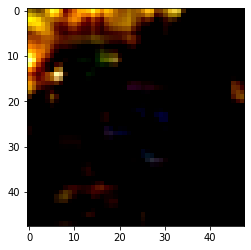

Label: tensor([13])


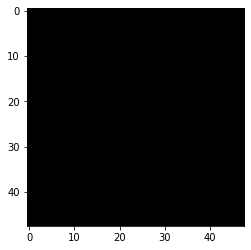

Label: tensor([34])


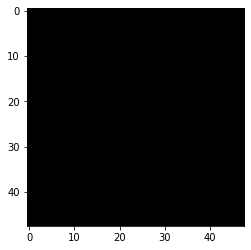

Label: tensor([3])


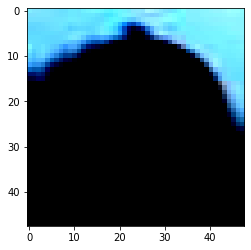

Label: tensor([41])


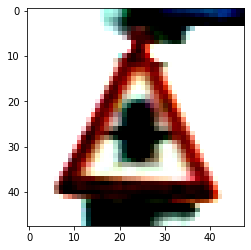

Label: tensor([4])


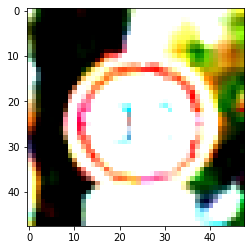

Label: tensor([2])


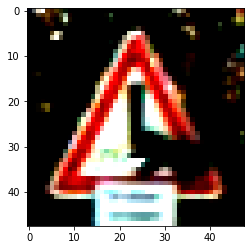

Label: tensor([11])


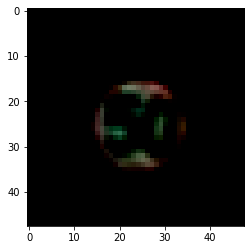

Label: tensor([13])


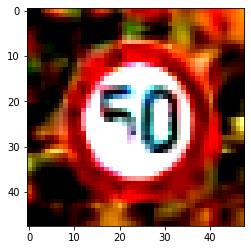

Label: tensor([13])


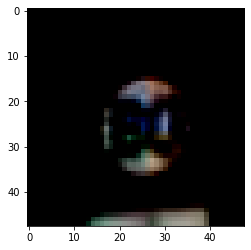

Label: tensor([38])


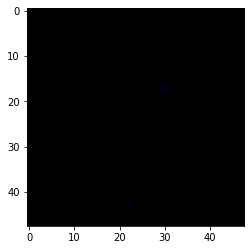

Label: tensor([3])


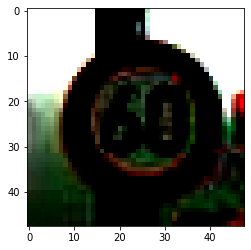

Label: tensor([23])


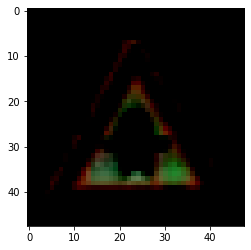

Label: tensor([4])


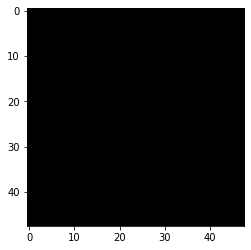

Label: tensor([39])


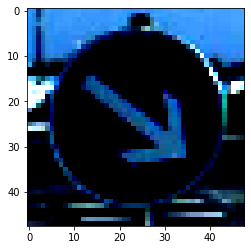

Label: tensor([32])


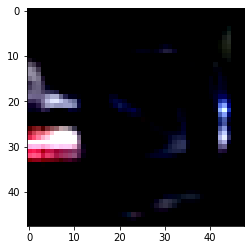

Label: tensor([32])


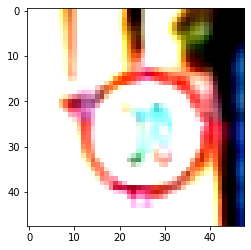

Label: tensor([2])


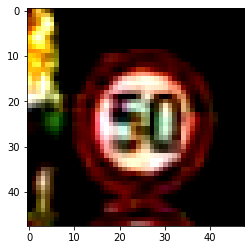

Label: tensor([13])


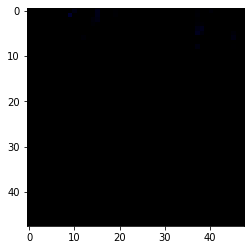

Label: tensor([40])


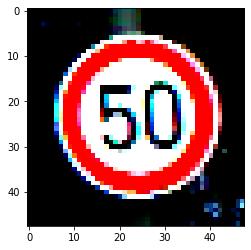

Label: tensor([13])


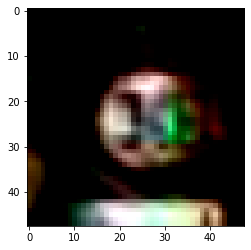

Label: tensor([2])


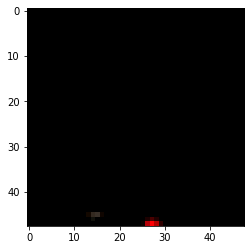

Label: tensor([5])


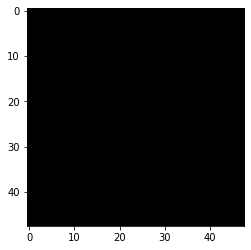

Label: tensor([3])


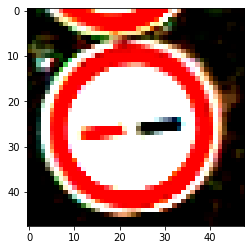

Label: tensor([42])


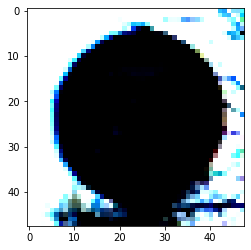

Label: tensor([13])


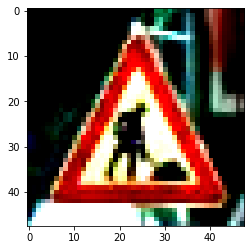

Label: tensor([19])


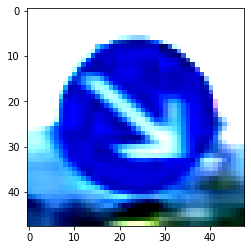

Label: tensor([32])


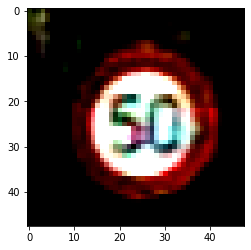

Label: tensor([13])


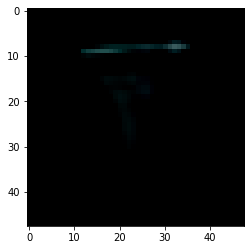

Label: tensor([6])


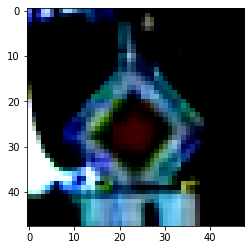

Label: tensor([5])


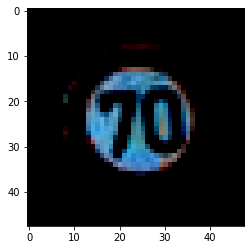

Label: tensor([34])


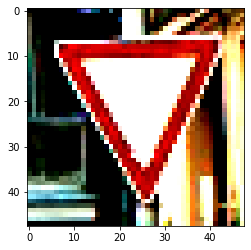

Label: tensor([6])


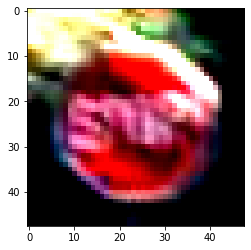

Label: tensor([7])


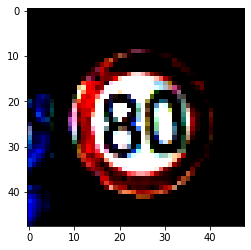

Label: tensor([38])


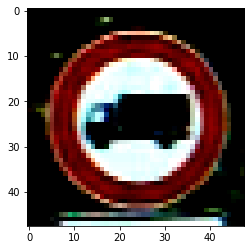

Label: tensor([9])


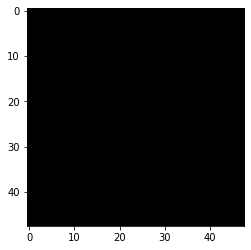

Label: tensor([39])


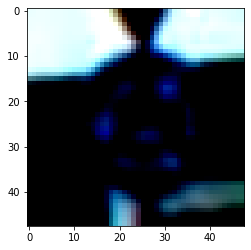

Label: tensor([35])


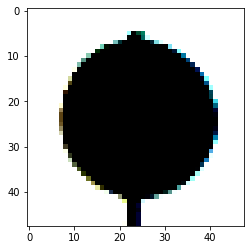

Label: tensor([34])


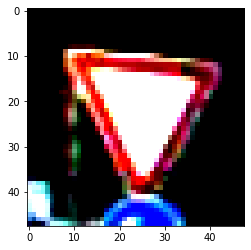

Label: tensor([6])


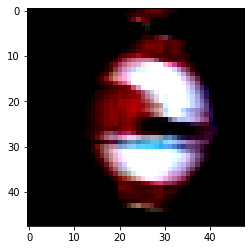

Label: tensor([3])


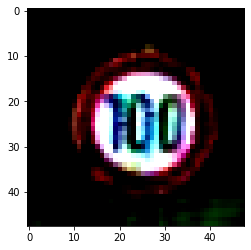

Label: tensor([40])


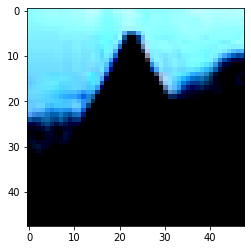

Label: tensor([17])


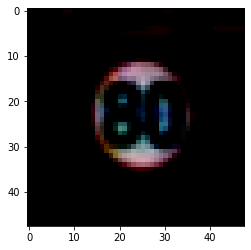

Label: tensor([38])


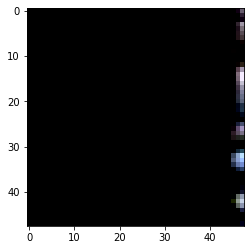

Label: tensor([34])


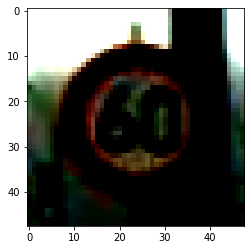

Label: tensor([23])


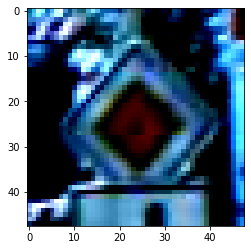

Label: tensor([5])


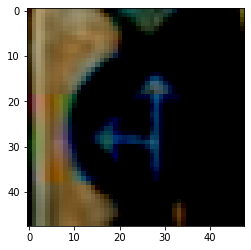

Label: tensor([31])


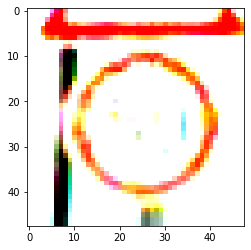

Label: tensor([13])


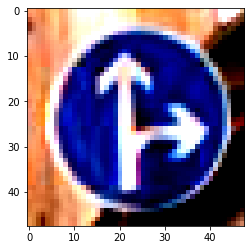

Label: tensor([30])


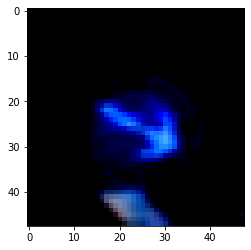

Label: tensor([32])


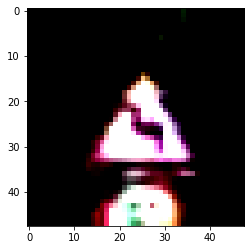

Label: tensor([15])


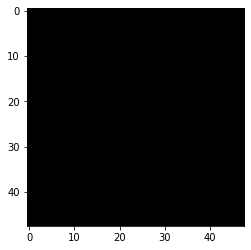

Label: tensor([5])


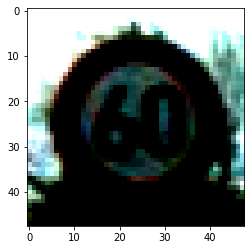

Label: tensor([23])


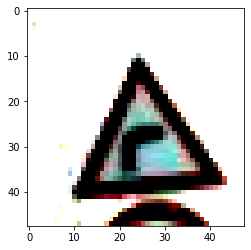

Label: tensor([14])


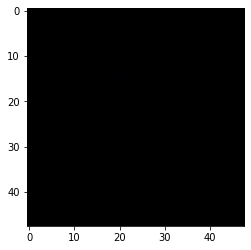

Label: tensor([2])


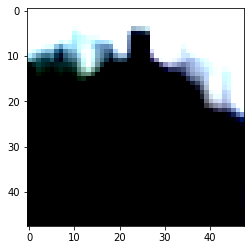

Label: tensor([23])


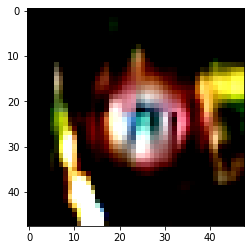

Label: tensor([34])


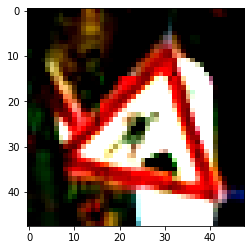

Label: tensor([19])


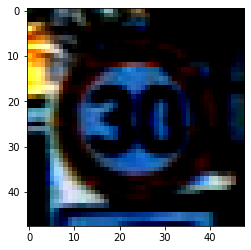

Label: tensor([2])


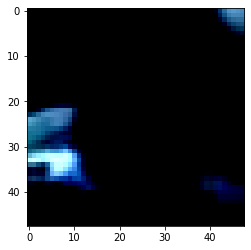

Label: tensor([41])


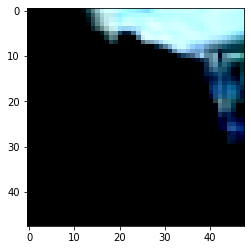

Label: tensor([34])


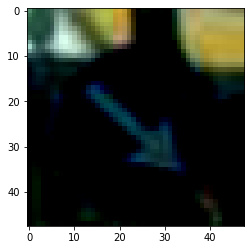

Label: tensor([32])


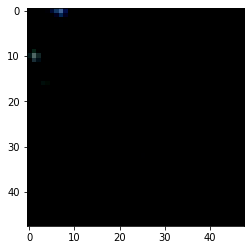

Label: tensor([23])


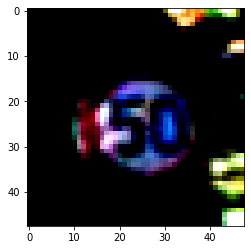

Label: tensor([13])


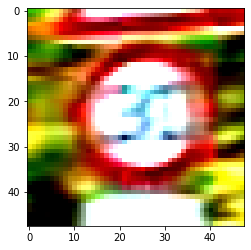

Label: tensor([2])


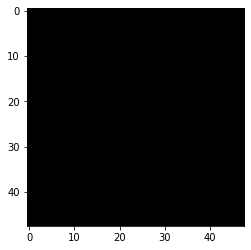

Label: tensor([38])


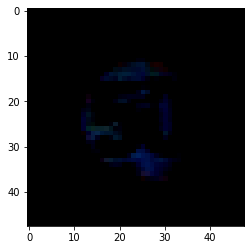

Label: tensor([13])


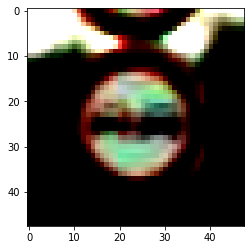

Label: tensor([42])


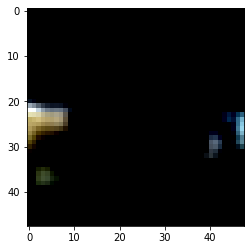

Label: tensor([42])


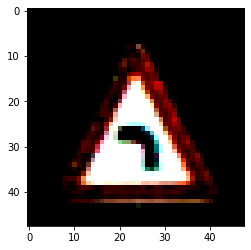

Label: tensor([12])


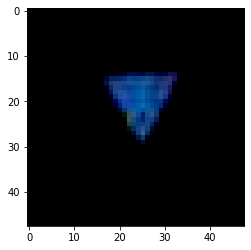

Label: tensor([6])


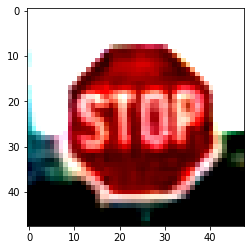

Label: tensor([7])


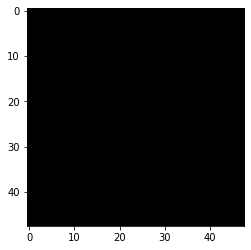

Label: tensor([3])


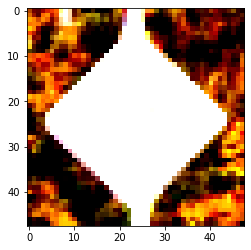

Label: tensor([5])


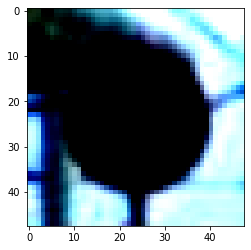

Label: tensor([23])


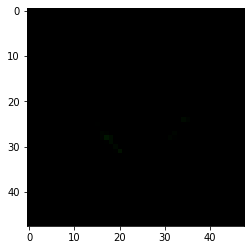

Label: tensor([5])


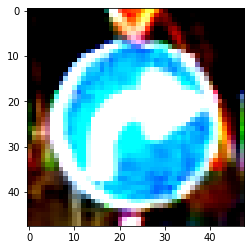

Label: tensor([27])


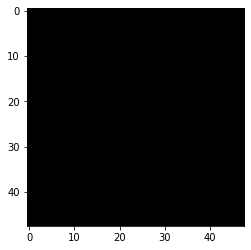

Label: tensor([23])


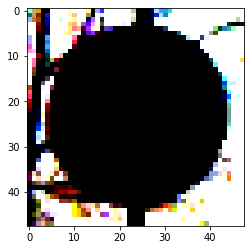

Label: tensor([13])


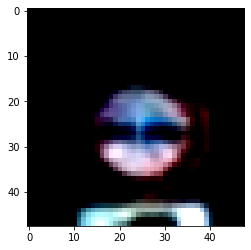

Label: tensor([42])


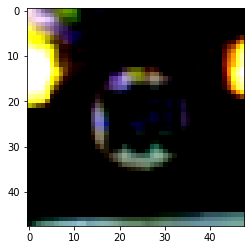

Label: tensor([40])


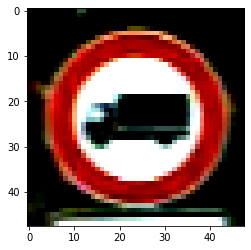

Label: tensor([9])


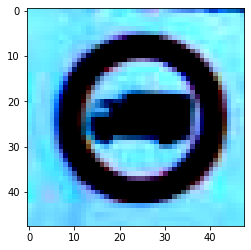

Label: tensor([9])


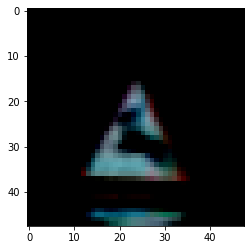

Label: tensor([25])


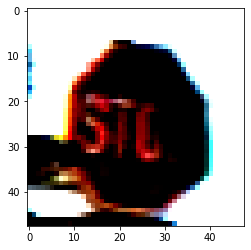

Label: tensor([7])


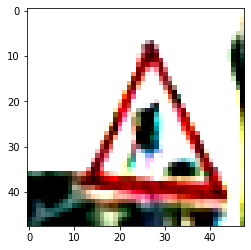

Label: tensor([19])


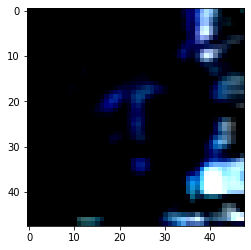

Label: tensor([29])


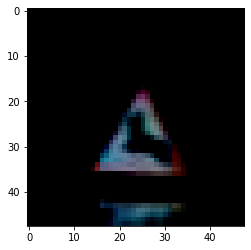

Label: tensor([25])


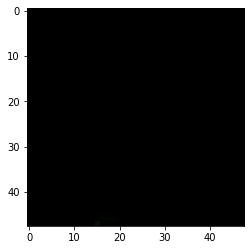

Label: tensor([38])


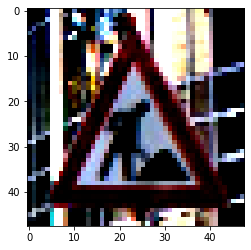

Label: tensor([19])


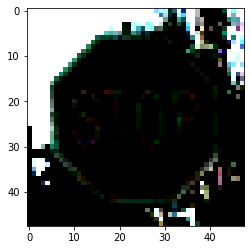

Label: tensor([7])


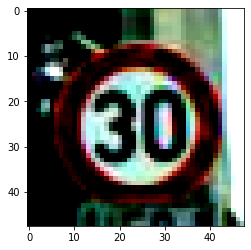

Label: tensor([2])


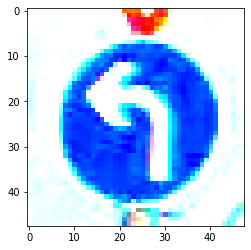

Label: tensor([28])


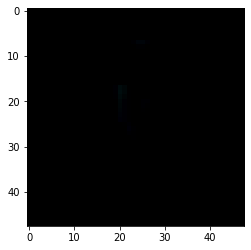

Label: tensor([6])


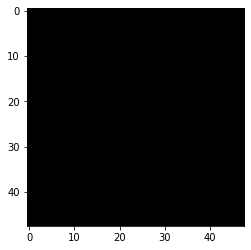

Label: tensor([3])


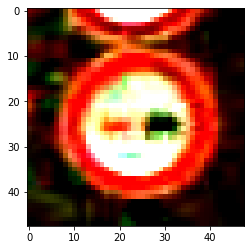

Label: tensor([42])


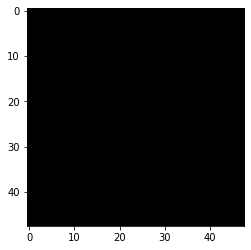

Label: tensor([37])


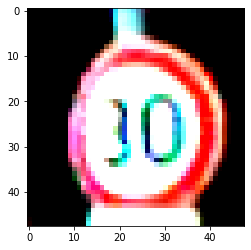

Label: tensor([2])


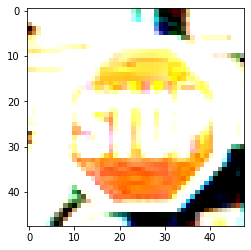

Label: tensor([7])


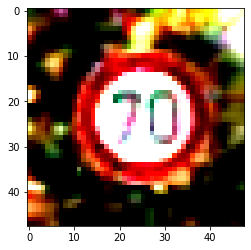

Label: tensor([34])


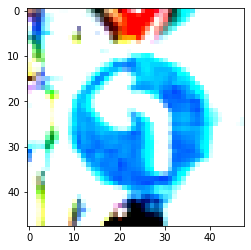

Label: tensor([28])


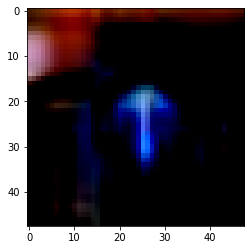

Label: tensor([29])


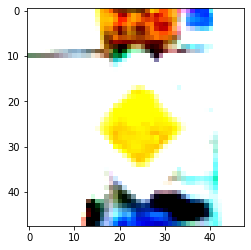

Label: tensor([5])


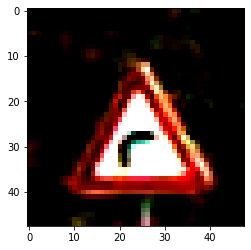

Label: tensor([14])


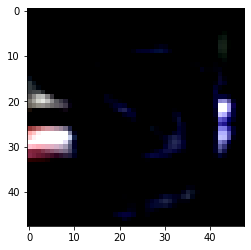

Label: tensor([32])


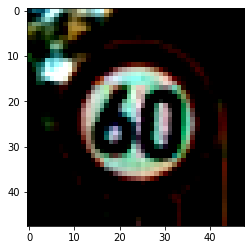

Label: tensor([23])


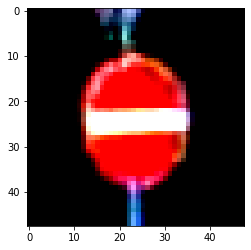

Label: tensor([10])


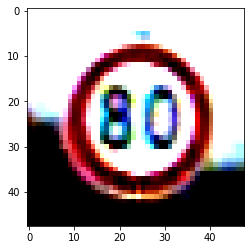

Label: tensor([38])


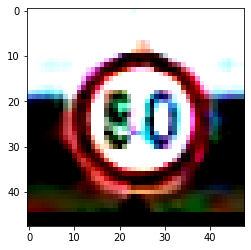

Label: tensor([38])


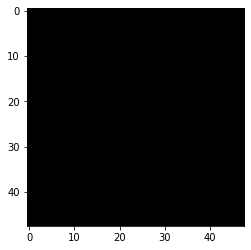

Label: tensor([25])


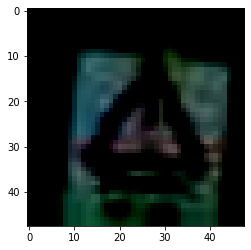

Label: tensor([11])


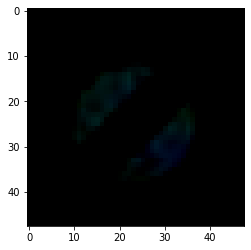

Label: tensor([26])


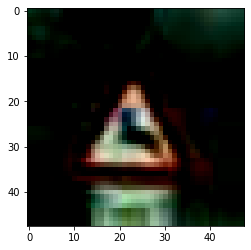

Label: tensor([25])


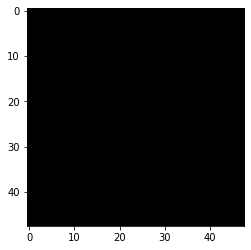

Label: tensor([24])


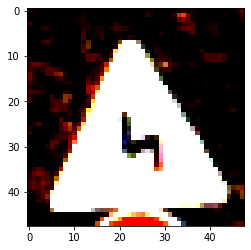

Label: tensor([15])


In [41]:
import time
import matplotlib.pyplot as plt

for batch_idx, (images, labels) in enumerate(test_loader):
    # Extract the labels from the current batch
    batch_labels = labels.numpy()

    plt.imshow(images[0].cpu().permute(1,2,0))
    plt.show()
    print(f"Label: {labels[0]}")

    #time.sleep (2)

In [30]:
from torchvision.models import resnet50, ResNet50_Weights

numClasses = 43   #12 classes + unknown 
net = models.resnet50(weights=ResNet50_Weights.DEFAULT)
net.fc = torch.nn.Linear(net.fc.in_features, numClasses)
net = net.to(device)
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)

In [ ]:
for epoch in range(6):
    running_loss = 0.0
    for i, (data, labels) in enumerate(train_loader):
        images, labels = data.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels.reshape(-1))
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
          print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100)) 
          running_loss = 0.0

In [ ]:
import time

correct = 0
total = 0

for i, (data, labels) in enumerate(test_loader):
        images, labels = data.to(device), labels.to(device)

        outputs = net(images)

        pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability

        labels = labels.reshape(-1)
        pred = pred.reshape(-1)

        
        #for i in range (len(pred)):
          #print (labels[i])
          #print (pred[i])
          #plt.imshow(images[i].cpu().permute(1,2,0))
          #plt.show()
        
        print (labels)
        print (pred)

        correct += (pred == labels).float().sum()
        total += len(pred)

        print ("Correct: " + str((pred == labels).float().sum()))
        #time.sleep (10)

'''
        print ("Correct : " + str(correct))
        print ("Label:")
        print (labels)
        print ("Pred:")
        print (pred)
        time.sleep(10)
'''

print ("Total: " + str(total))
print ("Test_loader.dataset: " + str(len(test_loader.dataset)))
print ("Test Accuracy: " + str (100*(correct/len(test_loader.dataset))))



In [ ]:
!rm -rf "/content/drive/My Drive/train_images/"
!rm -rf "/content/drive/My Drive/test_images/"

In [ ]:
drive.flush_and_unmount()

In [ ]:
tform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((48, 48)), 
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629)),
])

print (train.tensors.keys())

'''

for i in range (0, len(train)):
        train.labels[i] = 100 

for i, data in enumerate(train):
        image, label = data['images'], data['labels']
        print (label)

'''


train_loader = train.pytorch(num_workers=0, batch_size=64, transform={
                        'images': tform, 'labels': None}, shuffle=True)

test_loader = test.pytorch(num_workers=0, batch_size=64, transform={
                        'images': tform, 'labels': None}, shuffle=True)
'''
for i in range(0, len(train)):
        train.labels[1] = 100
        #images, labels = train.images[i], train.labels[i]

for i, data in enumerate(train):
        image, label = data['images'], data['labels']
        print (label)
        '''